# Portfolio Example

 Description of a portfolio strategy which results in a portfolio that matches the picture of S&P 500. 

A short demo with a simplistic approach

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

## Make the Risk Profile of the S&P 500

In [17]:
# Fetch historical data for S&P 500
sp500 = yf.download("^GSPC", start="2010-01-01", end="2024-11-01")['Adj Close']

# Calculate daily and annualized returns
daily_returns_sp500 = sp500.pct_change().dropna()
annualized_return_sp500 = np.mean(daily_returns_sp500) * 252
annualized_volatility_sp500 = daily_returns_sp500['^GSPC'].std() * np.sqrt(252)

[*********************100%***********************]  1 of 1 completed


In [18]:
# Risk-free rate (assume 2% for Sharpe Ratio calculation)
risk_free_rate = 0.02

# Calculate Sharpe Ratio
sharpe_ratio_sp500 = (annualized_return_sp500 - risk_free_rate) / annualized_volatility_sp500

# Calculate Maximum Drawdown
cumulative_returns_sp500 = (1 + daily_returns_sp500).cumprod()
peak = cumulative_returns_sp500.cummax()
drawdown = (cumulative_returns_sp500 - peak) / peak
max_drawdown = drawdown.min()

In [19]:
# Print results
print("S&P 500 Risk Profile:")
print(f"Annualized Return: {annualized_return_sp500 * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility_sp500 * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_sp500:.2f}")
print(f"Maximum Drawdown: {max_drawdown.iloc[0] * 100:.2f}%")

S&P 500 Risk Profile:
Annualized Return: 12.42%
Annualized Volatility: 17.27%
Sharpe Ratio: 0.60
Maximum Drawdown: -33.92%


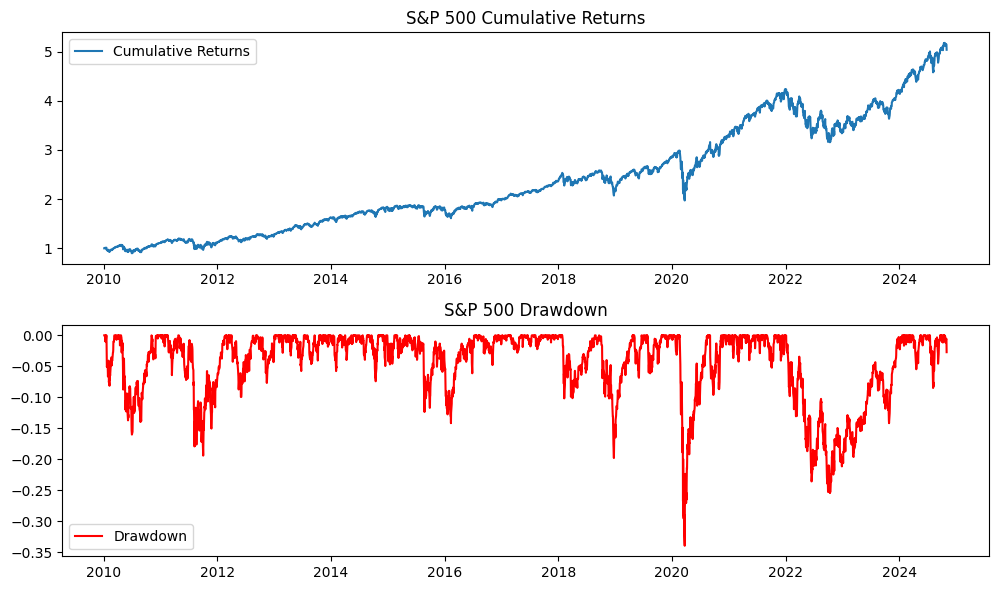

In [20]:
# Visualize the cumulative returns and drawdowns
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_sp500, label="Cumulative Returns")
plt.title("S&P 500 Cumulative Returns")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(drawdown, label="Drawdown", color="red")
plt.title("S&P 500 Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

## Construct the Portfolio

In [2]:
# Step 1: Fetch historical data for selected assets
# Assets chosen: 10-year Treasury bond (proxy for bonds), gold (GLD), Bitcoin (BTC-USD), and real estate (VNQ)
assets = ["^TNX", "GLD", "BTC-USD", "VNQ"]
data = yf.download(assets, start="2018-01-01", end="2024-11-01")['Adj Close']


[*********************100%***********************]  4 of 4 completed


In [3]:
# Step 2: Calculate daily returns from the price data
# Percentage change is calculated to represent daily returns
returns = data.pct_change(fill_method=None).dropna()

In [4]:
# Step 3: Simulate a "Private Credit" asset
# Generate synthetic returns for Private Credit as a low-volatility, stable asset
np.random.seed(0)  # Ensure reproducibility of results
private_credit_returns = np.random.normal(0.00015, 0.001, len(returns))  # ~0.015% mean daily return or ~6% annualized return with 1% volatility
returns['Private Credit'] = private_credit_returns


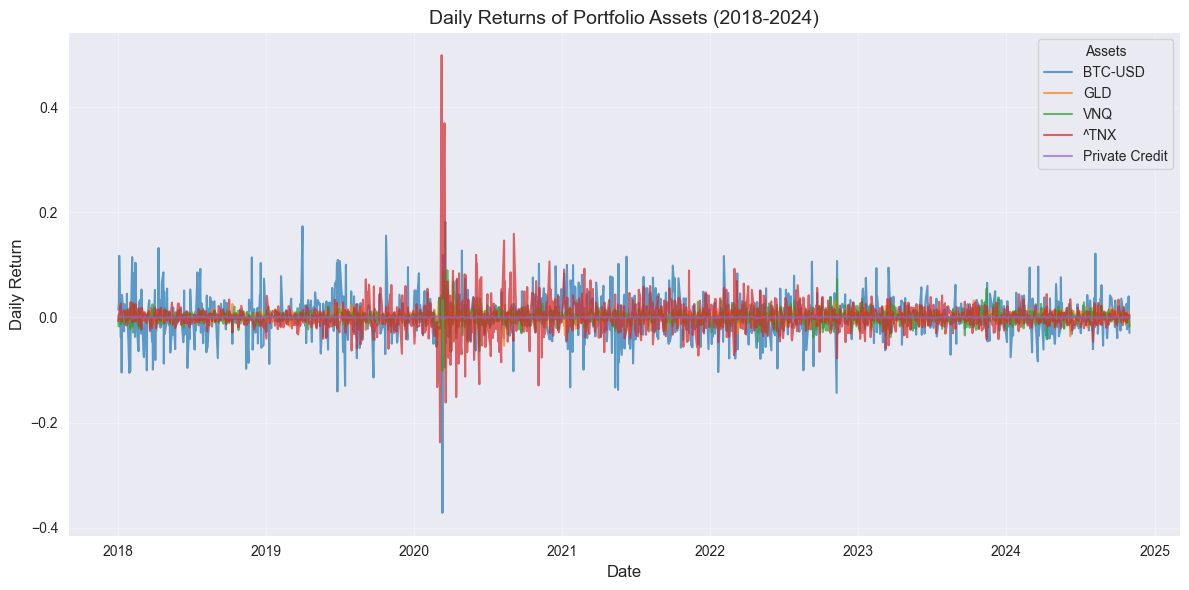

In [5]:
# Plot the returns of the assets in the portfolio
plt.figure(figsize=(12, 6))
for asset in returns.columns:
    plt.plot(returns[asset], label=asset, alpha=0.7)  # Use alpha for better visibility in overlapping lines

# Step 5: Add labels, title, and legend
plt.title("Daily Returns of Portfolio Assets (2018-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Return", fontsize=12)
plt.legend(title="Assets", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

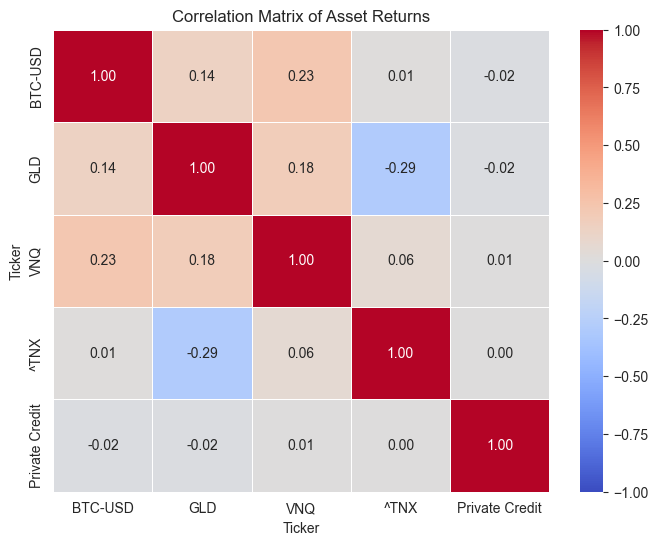

In [6]:
# Step 4: Compute the correlation matrix of asset returns
correlation_matrix = returns.corr()

# Step 5: Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Asset Returns")
plt.show()

In [7]:
# Step 6: Calculate annualized returns and the covariance matrix
# Annualized returns assume 252 trading days in a year
mean_returns = returns.mean() * 252  # Mean daily returns annualized
cov_matrix = returns.cov() * 252    # Covariance matrix annualized

# Set the risk-free rate (e.g., yield on a risk-free asset like Treasury bonds)
risk_free_rate = 0.02  # 2% annualized risk-free return

# Define target return and volatility to mimic an S&P 500-like risk profile
target_volatility = annualized_volatility_sp500  # ~17.27% annualized volatility
target_return = annualized_return_sp500      # ~12.42% annualized return


In [8]:
# Step 7: Define a function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility for a given set of weights.
    """
    returns = np.sum(mean_returns * weights)  # Weighted average return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility
    return returns, volatility

# Step 8: Define the objective function for optimization
def objective_function(weights, mean_returns, cov_matrix, target_return, target_volatility):
    """
    Objective function to maximize the Sharpe ratio while penalizing concentration.
    """
    # Calculate portfolio returns and volatility
    returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)

    # Calculate Sharpe ratio
    sharpe_ratio = (returns - risk_free_rate) / volatility

    # Add a concentration penalty to avoid over-concentration in a few assets
    concentration_penalty = np.sum(weights**2)  # Penalizes high concentration
    penalty_factor = 10  # Adjustable factor for the penalty strength

    # Return the negative of the Sharpe ratio (we're minimizing)
    return -sharpe_ratio + penalty_factor * concentration_penalty


In [9]:
# Step 9: Define constraints
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: target_return - np.sum(mean_returns * x)},  # Return >= target return
    {'type': 'ineq', 'fun': lambda x: target_volatility - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))},  # Volatility <= target volatility
)


In [10]:
# Step 10: Define initial guess and bounds for optimization
num_assets = len(mean_returns)
initial_guess = num_assets * [1. / num_assets,]  # Equal allocation as the starting point
bounds = tuple((0, 1) for _ in range(num_assets))  # Long-only portfolio (weights between 0 and 1)


In [11]:
# Step 9: Perform the optimization
result = minimize(objective_function,initial_guess,args=(mean_returns, cov_matrix, target_return, target_volatility),method='SLSQP',constraints=constraints)


In [12]:
# Extract the optimized weights
optimized_weights = result.x

# Step 10: Calculate portfolio performance with optimized weights
opt_returns, opt_volatility = portfolio_performance(optimized_weights, mean_returns, cov_matrix)
opt_sharpe_ratio = (opt_returns - risk_free_rate) / opt_volatility


In [13]:
# Additional Risk Metrics
# Value at Risk (VaR)
def calculate_value_at_risk(returns, weights, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) at a given confidence level.
    """
    portfolio_returns = returns.dot(weights)
    var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var

# Conditional Value at Risk (CVaR)
def calculate_cvar(returns, weights, confidence_level=0.95):
    """
    Calculate Conditional Value at Risk (CVaR).
    """
    portfolio_returns = returns.dot(weights)
    var = calculate_value_at_risk(returns, weights, confidence_level)
    cvar = -portfolio_returns[portfolio_returns <= -var].mean()
    return cvar

# Max Drawdown
def calculate_max_drawdown(portfolio_returns):
    """
    Calculate the maximum drawdown of the portfolio.
    """
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [14]:
# Calculate additional risk metrics
portfolio_returns = returns.dot(optimized_weights)  # Portfolio daily returns
value_at_risk = calculate_value_at_risk(returns, optimized_weights)
conditional_var = calculate_cvar(returns, optimized_weights)
max_drawdown = calculate_max_drawdown(portfolio_returns)

In [15]:
# Display optimized weights and portfolio performance
portfolio_weights = pd.DataFrame({'Asset': mean_returns.index, 'Weight': optimized_weights})
print("Optimized Portfolio Weights:")
print(portfolio_weights)
print("\nExpected Annual Return:", round(opt_returns * 100, 2), "%")
print("Expected Annual Volatility:", round(opt_volatility * 100, 2), "%")
print("Sharpe Ratio:", round(opt_sharpe_ratio, 2))
print("Value at Risk (95%):", round(value_at_risk, 4))
print("Conditional VaR (95%):", round(conditional_var, 4))
print("Maximum Drawdown:", round(max_drawdown, 4))

Optimized Portfolio Weights:
            Asset    Weight
0         BTC-USD  0.075609
1             GLD  0.260923
2             VNQ  0.215453
3            ^TNX  0.138937
4  Private Credit  0.309078

Expected Annual Return: 12.42 %
Expected Annual Volatility: 11.12 %
Sharpe Ratio: 0.94
Value at Risk (95%): 0.0093
Conditional VaR (95%): 0.0148
Maximum Drawdown: -0.1093


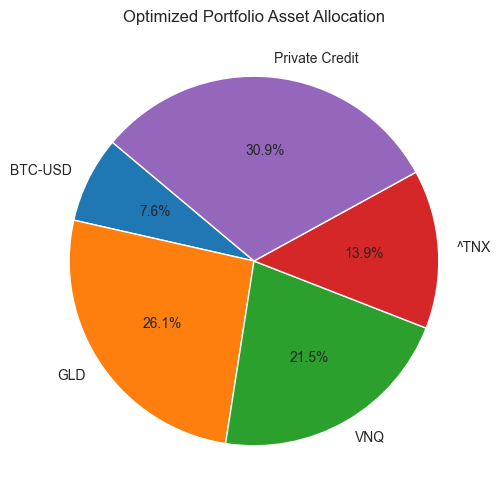

In [16]:
# Visualization: Plot pie chart of asset allocation
plt.figure(figsize=(10, 6))
plt.pie(optimized_weights, labels=mean_returns.index, autopct='%1.1f%%', startangle=140)
plt.title("Optimized Portfolio Asset Allocation")
plt.show()
